In [2]:
import tensorflow as tf

help(tf.nn.depthwise_conv2d)



Help on function depthwise_conv2d in module tensorflow.python.ops.nn_impl:

depthwise_conv2d(input, filter, strides, padding, rate=None, name=None, data_format=None)
    Depthwise 2-D convolution.
    
    Given a 4D input tensor ('NHWC' or 'NCHW' data formats)
    and a filter tensor of shape
    `[filter_height, filter_width, in_channels, channel_multiplier]`
    containing `in_channels` convolutional filters of depth 1, `depthwise_conv2d`
    applies a different filter to each input channel (expanding from 1 channel
    to `channel_multiplier` channels for each), then concatenates the results
    together.  The output has `in_channels * channel_multiplier` channels.
    
    In detail,
    
        output[b, i, j, k * channel_multiplier + q] = sum_{di, dj}
             filter[di, dj, k, q] * input[b, strides[1] * i + rate[0] * di,
                                             strides[2] * j + rate[1] * dj, k]
    
    Must have `strides[0] = strides[3] = 1`.  For the most common case

_______________
[[-1.95959357 -0.75422196]
 [ 1.45966183  0.95204968]
 [ 0.52075044 -1.1865112 ]
 ..., 
 [-0.78376623 -3.49346493]
 [-0.61941384 -0.42135768]
 [-0.47320846  0.72340791]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
_______________


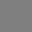

In [ ]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Mon Sep  4 13:43:09 2017
Author: Peiyong Jiang : jiangpeiyong@impcas.ac.cn
Function:


"""


import tensorflow as tf
import numpy as np

#导入可视化需要的库
import PIL.Image
#from io import StringIO
from io import BytesIO as StringIO
from IPython.display import clear_output, Image, display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.close('all')

#然后，我们还需要一个用于表示池塘表面状态的函数。

def DisplayArray(a, fmt='jpeg', rng=[0,1]):
  """Display an array as a picture."""
  a = (a - rng[0])/float(rng[1] - rng[0])*255
  a = np.uint8(np.clip(a, 0, 255))
  f = StringIO()
  PIL.Image.fromarray(a).save(f, fmt)
  
  display(Image(data=f.getvalue()))

#最后，为了方便演示，这里我们需要打开一个 TensorFlow 的交互会话（interactive session）。当然为了以后能方便调用，我们可以把相关代码写到一个可以执行的Python文件中。

sess = tf.InteractiveSession()

#定义计算函数

def make_kernel(a):
  """Transform a 2D array into a convolution kernel"""
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return tf.constant(a, dtype=1)

def simple_conv(x, k):
  """A simplified 2D convolution operation"""
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
  return y[0, :, :, 0]

def laplace(x):
  """Compute the 2D laplacian of an array"""
  laplace_k = make_kernel([[0.5, 1.0, 0.5],
                           [1.0, -6., 1.0],
                           [0.5, 1.0, 0.5]])
  return simple_conv(x, laplace_k)

#定义偏微分方程

#首先,我们需要创建一个完美的 500 × 500 的正方形池塘,就像是我们在现实中找到的一样。

N = 32

#然后，我们需要创建了一个池塘和几滴将要坠入池塘的雨滴。

# Initial Conditions -- some rain drops hit a pond

# Set everything to zero
u_init = np.zeros([N, N], dtype="float32")
ut_init = np.zeros([N, N], dtype="float32")

'''
# Some rain drops hit a pond at random points
for n in range(4):
  a,b = np.random.randint(0, N, 2)
  u_init[a,b] = np.random.uniform()

print(u_init)
'''
disPart=np.random.multivariate_normal([0,0],[[1.,0.],[0.,3.]],1000)
'''
plt.figure(1)
plt.clf()
plt.plot(disPart[:,0],disPart[:,1],'.')
plt.show()
'''

print('_______________')
print(disPart)
allHistDisPart=np.histogram2d(disPart[:,0],disPart[:,1],[N,N])
histDisPart=allHistDisPart[0]
print('===============')
print(histDisPart)
print('_______________')

xEdge,yEdge=allHistDisPart[1],allHistDisPart[2]

xGrid,yGrid=np.meshgrid((xEdge[0:-1:]+xEdge[1::])/2.,(yEdge[0:-1:]+yEdge[1::])/2.)

ut_init=np.float32(histDisPart)



    
DisplayArray(u_init, rng=[-0.1, 0.1])

#jpeg

#现在，让我们来指定该微分方程的一些详细参数。

# Parameters:
# eps -- time resolution
# damping -- wave damping
eps = tf.placeholder(tf.float32, shape=())
damping = tf.placeholder(tf.float32, shape=())

# Create variables for simulation state
U  = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

# Discretized PDE update rules
#U_ = U + eps * Ut
#Ut_ = Ut + eps * (laplace(U) - damping * Ut)

U_ =  Ut
Ut_ = laplace(U)

# Operation to update the state
step = tf.group(
  U.assign(U_),
  Ut.assign(Ut_))

#开始仿真

#为了能看清仿真效果，我们可以用一个简单的 for 循环来远行我们的仿真程序。

# Initialize state to initial conditions
tf.global_variables_initializer().run()



# Run 1000 steps of PDE
for i in range(100):
  # Step simulation
  step.run({eps: 0.03, damping: 0.04})
  # Visualize every 50 steps
  if i % 50 == 0:
    clear_output()
    #DisplayArray(U.eval(), rng=[-0.1, 0.1])
    #fig = plt.figure(1)
    #plt.clf()
    #ax = fig.add_subplot(111,projection='3d')
    #ax.scatter(xGrid,yGrid,U.eval())
    #plt.show()
    
    
    uTemp=list(U.eval())
    uArray=np.array(uTemp)

    
    fig = plt.figure(1)
    plt.clf()
    ax = fig.add_subplot(111,projection='3d')
    ax.plot_surface(xGrid,yGrid,uArray)
    plt.show()    
    
    
    #print(np.shape(xGrid))
    
    plt.pause(0.3)


print('END')



In [1]:
help(tf.nn)

NameError: name 'tf' is not defined

In [2]:
import tensorflow as tf
help(tf.nn.depthwise_conv2d)

Help on module tensorflow.python.ops.nn in tensorflow.python.ops:

NAME
    tensorflow.python.ops.nn - Neural network support.

FILE
    /home/A/SW/Anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn.py

DESCRIPTION
    See the @{$python/nn} guide.
    
    @@relu
    @@relu6
    @@crelu
    @@elu
    @@softplus
    @@softsign
    @@dropout
    @@bias_add
    @@sigmoid
    @@tanh
    @@convolution
    @@conv2d
    @@depthwise_conv2d
    @@depthwise_conv2d_native
    @@separable_conv2d
    @@atrous_conv2d
    @@atrous_conv2d_transpose
    @@conv2d_transpose
    @@conv1d
    @@conv3d
    @@conv3d_transpose
    @@conv2d_backprop_filter
    @@conv2d_backprop_input
    @@conv3d_backprop_filter_v2
    @@depthwise_conv2d_native_backprop_filter
    @@depthwise_conv2d_native_backprop_input
    @@avg_pool
    @@max_pool
    @@max_pool_with_argmax
    @@avg_pool3d
    @@max_pool3d
    @@fractional_avg_pool
    @@fractional_max_pool
    @@pool
    @@dilation2d
    @@erosion2d
    @@with